In [1]:
import scipy
from scipy import stats
import pandas as pd

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [130]:
class Meta(object):
    
    def __init__(self, metashare: np.array, matchups: np.array, stepsize: float = .01):
        
        self.metashare = metashare
        self.matchups = matchups
        self.stepsize = stepsize
        
        self.n_decks = len(metashare)
        
        # initialize the evolving meta
        self._metas = [self.metashare]
        
    @property
    def metas(self):
        # this is a convenience method to return a np.array instead of a list of arrays
        return np.vstack(self._metas)
    
    def choose_next_deck(self):
        ## choose the best deck according to win percentages in the current meta
        curr_meta = self._metas[-1]
        return np.argmax(self.matchups @ curr_meta)
        
    def step(self):
        ## copy the current meta, choose a new deck and update
        next_deck = self.choose_next_deck()
        new_meta = self._metas[-1].copy()
        new_meta[next_deck] += self.stepsize

        new_meta = (new_meta / np.sum(new_meta))
        self._metas.append(new_meta)
   
    def evolve(self, steps: int) -> np.array:
        ## evolve the metagame, return the full array of metagames
        
        for i in range(steps): self.step()
        return self.metas
    
    def randomize_start(self):
        
        ## convenience for evaluating the influence of starting metashares
        return self.__class__(self.__class__.random_start(self.n_decks), self.matchups)
    
    @staticmethod
    def random_start(n_decks: int) -> np.array:

        meta = np.abs(stats.norm().rvs(n_decks))
        return meta / np.sum(meta)

    @staticmethod
    def random_matchups(n_decks: int, sd: float = .5) -> np.array:
        
        ## generate a matrix with matchup probabilities
        m = stats.norm().rvs((n_decks, n_decks)) * sd
        
        ## transposing makes sure the matrix is skew-symmetrics
        ## we then use the logit to convert to probabilities
        return scipy.special.expit(m - m.T)
    
    @classmethod
    def random_init(cls, n_decks: int, sd: float = .5):
        ## this returns a new meta with randomly initialized share and matchups
        
        return cls(cls.random_start(n_decks), cls.random_matchups(n_decks, sd))

In [131]:
from matplotlib.ticker import FuncFormatter

def to_percent(y, position):
    # Ignore the passed in position. This has the effect of scaling the default
    # tick locations.
    return f'{int(y * 100)}%'

percent_formatter = FuncFormatter(to_percent)

to_percent(.05, 1)

'5%'

Text(0.5,0.98,'Simulated evolution of 16 randomized metagames with 5 decks')

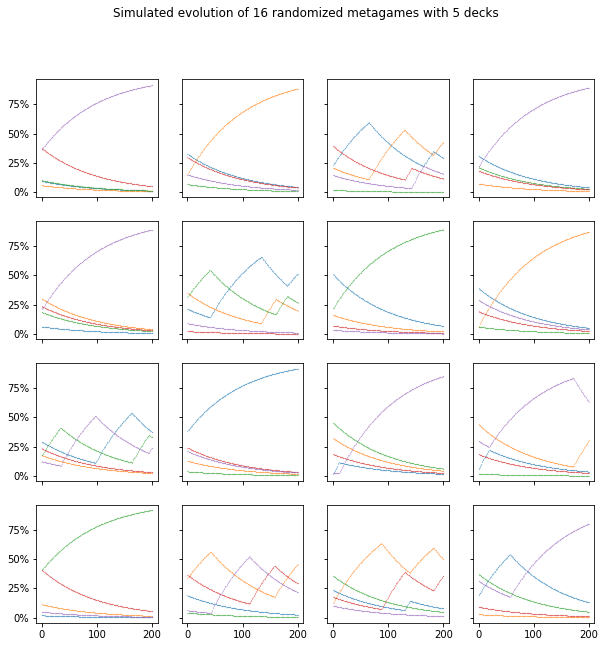

In [148]:
## a function to show the evolution of different metas in one plot

def show_simulated_metas(metas, steps):

    ncol = int(np.ceil(np.sqrt(len(metas))))
    nrow = int(np.ceil(len(metas) / ncol))
    
    f, axes = plt.subplots(nrow, ncol, sharey=True, sharex=True, figsize=(10, 10))

    for i, meta in enumerate(metas):

        row, col = i // ncol, i % ncol
        ax = axes[row, col]
        ax.yaxis.set_major_formatter(percent_formatter)
        pd.DataFrame(meta.evolve(steps)).plot(ax = ax, legend = False, style = ".", markersize = .3)
        
    return f
        
fig = show_simulated_metas([Meta.random_init(5) for i in range(16)], 200)
fig.suptitle("Simulated evolution of 16 randomized metagames with 5 decks")

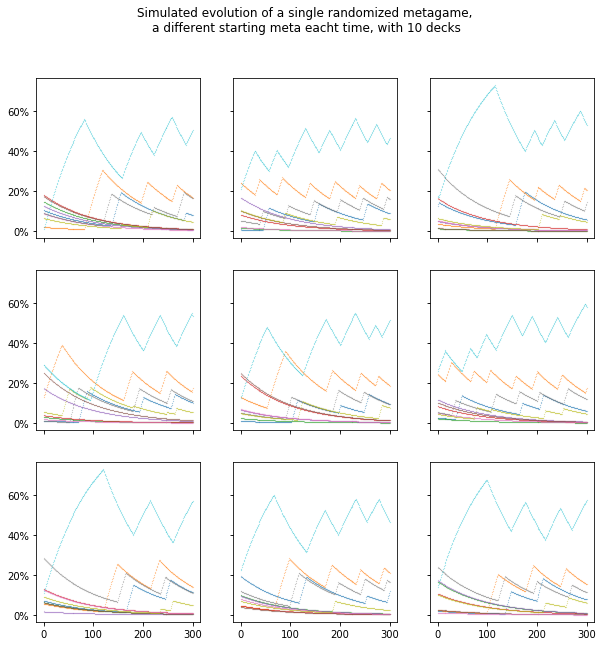

In [149]:
m = Meta.random_init(10)

fig = show_simulated_metas([m.randomize_start() for i in range(9)], 300)
fig.suptitle("Simulated evolution of a single randomized metagame, \na different starting meta eacht time, with 10 decks");

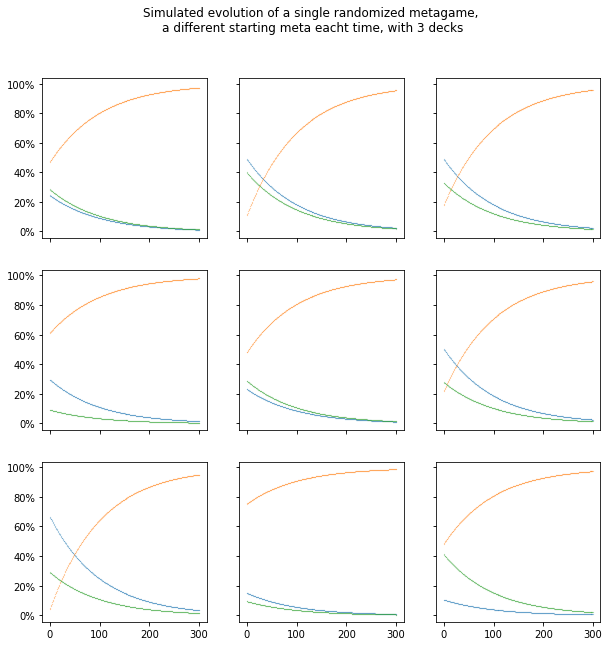

In [150]:
m = Meta.random_init(3)

fig = show_simulated_metas([m.randomize_start() for i in range(9)], 300)
fig.suptitle("Simulated evolution of a single randomized metagame, \na different starting meta eacht time, with 3 decks");

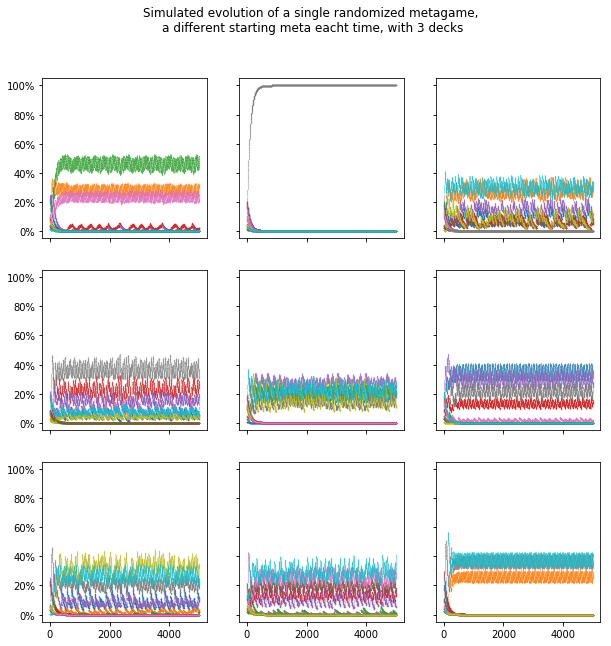

In [151]:
fig = show_simulated_metas([Meta.random_init(10) for i in range(9)], 5000)
fig.suptitle("Simulated evolution of a single randomized metagame, \na different starting meta eacht time, with 3 decks");

In [160]:
class WinSensitiveMeta(Meta):
    def __init__(self, metashare, matchups, win_sensitivity):
        
        super().__init__(metashare, matchups)
        self.win_sensitivity = win_sensitivity
    
    def choose_next_deck(self):
        curr_meta = self._metas[-1]
        p = np.exp(self.matchups @ curr_meta * self.win_sensitivity)
        return np.random.choice(list(range(len(p))), p = p / np.sum(p))        
    
    @classmethod
    def random_init(cls, n_decks: int, win_sensitivity: float = 0, sd: float = .5):
        return cls(cls.random_start(n_decks), cls.random_matchups(n_decks, sd), win_sensitivity)

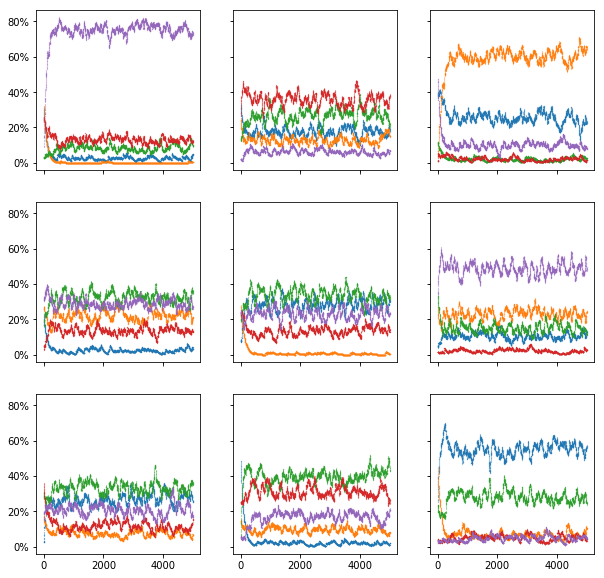

In [161]:
fig = show_simulated_metas([WinSensitiveMeta.random_init(n_decks=5, win_sensitivity=20) for i in range(9)], 5000);